# Some preliminary python code

In [8]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import graphviz

# Feature selection : embedded

With Embedded algorithms, the ML algorithm is designed to select a subset of the features. We see below two examples with :
- linear regression with L1 penalty with the LASSO algorithm
- classification trees with limited depth

## Embedded : regression with LASSO

An algorithm with embedded feature selection is an algorithm which encompasses, in its processing, a mean to reduce the number of features that impact the decision of the algorithm. For example, given $(x_i, y_i)$ a regression dataset, the LASSO algorithm seeks to minimize :
$$
\min_{\theta, \beta} \sum_{i=1}^N \frac{1}{N}||y_i -  \theta^T x_i - \beta||_2^2 + \alpha ||\theta||_1
$$

i.e. regression with a linear model $\beta + \theta^T x$, with a L1 regularization on the slope $\theta$, and $||\theta||_1 = \sum_j |\theta_j|$. It turns out that L1 penalty (the term $||\theta||_1$) promotes sparsity, i.e. a lot of the coefficients in the resulting $\theta$ will be <u>exactly</u> zero. 

The point of this section is not to provide details about how we solve this optimization problem but to see that it actually leads to select some of the features.

To illustrate this, we consider a regression problem. The function we would like to regress is :
$$
f(x) = 0.5 + 0.4 \sin(2\pi x)
$$

We are provided N=30 samples $(x_i, y_i) \in \mathbb{R}^2$ and we suppose these are given by :
$$
y_i = f(x) + \mathcal{N}(0, 0.05)
$$

An example of such samples is provided below; the training set is the points indicated by the star marker.

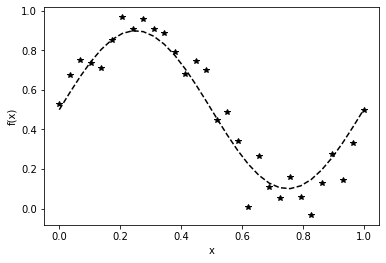

In [9]:
N = 30

f = lambda x : 0.5 + 0.4 * np.sin(2.0 * np.pi * x)

xi =  np.linspace(0.0, 1.0, num=N)
yi = f(xi) + np.sqrt(0.01) * np.random.randn(N)

plt.figure()
plt.plot(xi, yi, 'k*')
plt.plot(xi, f(xi), 'k--')
plt.xlabel(r"x")
plt.ylabel(r"f(x)")
plt.show()


The function we want to regress is clearly not linear. We will learn a linear model from non linear features of the inputs $x_i$ and here consider RBF features. We will use the same number of RBF features than input points, i.e. 30. This means that each sample $x_i$ is projected to $\phi(x_i)$ such that :
$$ 
\phi(x_i) = \begin{pmatrix} \exp(\frac{-||x_i-x_0||_2^2}{2\sigma^2}) \\ \exp(\frac{-||x_i-x_1||_2^2}{2\sigma^2}) \\ \vdots \\ \exp(\frac{-||x_i-x_{N-1}||_2^2}{2\sigma^2}) \end{pmatrix}
$$

And therefore our model is $\hat{y}_i = \beta + \theta^T \phi(x_i)$  where $\hat{y}_i$ is the predicted value at $x_i$.

Exactly 5 dimensions have non-zero coefficient
Offset : 0.5910647225018196
Theta : [ 0.          0.          0.          0.          0.          0.
  0.          0.10959292  0.21706115  0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.35679145 -0.         -0.         -0.
 -0.04913292 -0.30313037 -0.         -0.         -0.         -0.        ]


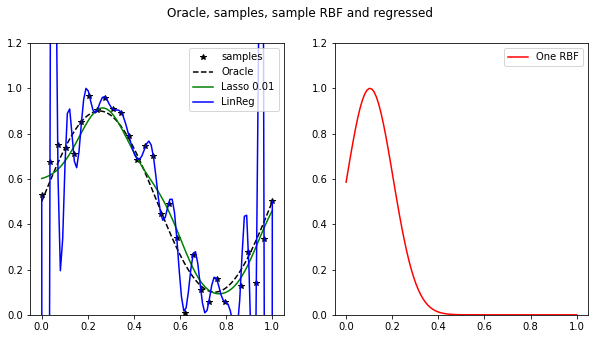

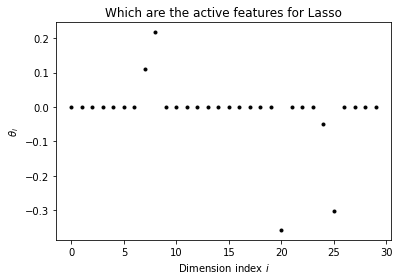

In [10]:
from sklearn import linear_model


# Build up the features as RBF features, one RBF per point
# Each sample phi(x_i) must be placed as a row in the following matrix X :
sigma = 3.0 / N
xrbf = xi 
xx, yy = np.meshgrid(xrbf, xrbf)
X = np.exp(-(yy - xx)**2/(2.0 * sigma**2))

lasso = linear_model.Lasso(alpha = 0.01)
lasso.fit(X, yi)

theta = lasso.coef_
beta = lasso.intercept_

print(r"Exactly {} dimensions have non-zero coefficient".format( (theta != 0).sum()))
print("Offset : {}".format(beta))
print("Theta : {}".format(theta))

linreg = linear_model.LinearRegression().fit(X, yi)
theta_linreg = linreg.coef_
beta_linreg = linreg.intercept_


x_fine = np.linspace(0, 1, num=100)
xx, yy = np.meshgrid(xrbf, x_fine)
X_fine = np.exp(-(yy - xx)**2/(2.0 * sigma**2))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(xi, yi, 'k*', label="samples")
plt.plot(x_fine, f(x_fine), 'k--', label="Oracle")
plt.plot(x_fine, np.dot(X_fine, theta) + beta, 'g-', label="Lasso 0.01")
plt.plot(x_fine, np.dot(X_fine, theta_linreg) + beta_linreg, 'b-', label="LinReg")
plt.ylim(0, 1.2)
plt.suptitle("Oracle, samples, sample RBF and regressed")
plt.legend()

plt.subplot(122)
plt.plot(x_fine, X_fine[:,3], 'r-', label="One RBF")
plt.ylim(0, 1.2)
#plt.title("Oracle, samples, sample RBF and regressed")
plt.legend()

plt.show()

plt.figure()
plt.plot(theta, 'k.')
plt.ylabel(r"$\theta_i$")
plt.xlabel(r"Dimension index $i$")
plt.title("Which are the active features for Lasso")
plt.show()

## Embedded: classification with classification trees

Classification and regression trees are another example of embedded methods. Indeed, each node encompasses a decision on one variable and if you only keep the variables that are used for the decision if the nodes, you indeed keep only a fraction of the input dimensions. 

As a matter of example, we illustre below the use of decision trees for feature selection in the case of a classification problem (categorical target).

Accuracy on the train set : 96.89 %
Accuracy on the test set : 91.86 %
Feature importance : [0.         0.01689685 0.         0.         0.         0.
 0.         0.         0.         0.         0.00321845 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01117069 0.         0.78854489
 0.         0.         0.0209961  0.15917302 0.         0.        ]
The decision tree selected 6 features out of the 30, which have the indices [ 1 10 21 23 26 27], i.e. ['mean texture', 'radius error', 'worst texture', 'worst area', 'worst concavity', 'worst concave points']


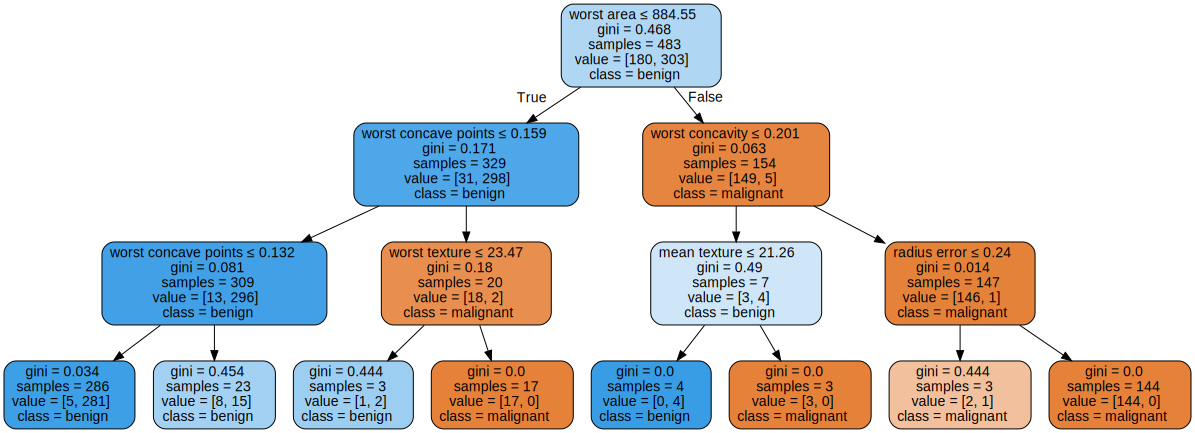

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn import tree
from sklearn.model_selection import train_test_split

data  = load_breast_cancer()

n_samples = data['data'].shape[0]
n_features = data['data'].shape[1]

# We split the dataset with 15% as a test, using stratified to ensure the train and test sets
# both have approximately the same statistics as the whole dataset
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], stratify=data['target'], test_size=0.15)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_accuracy = 100 * (y_train_pred == y_train).sum() / y_train.size
print("Accuracy on the train set : {:.2f} %".format(train_accuracy))

y_test_pred = clf.predict(X_test)
test_accuracy = 100 * (y_test_pred == y_test).sum() / y_test.size
print("Accuracy on the test set : {:.2f} %".format(test_accuracy))

# As suggested by Breiman et al.,  the cumulative decrease in Gini index reflects the importance of the variables
# The Gini index of a set of samples estimates the probability of misclassifying a sample given the class is 
# assigned randomly with respect to the density of the classes
# E.g.  a set of samples belonging to 3 classes with distribution S = [10, 20, 30] has a Gini index of 0.61
#       Denote f1 = 10/(10 + 20 + 30) = 1/6 ,   f2 = 20/(10 + 20 + 30) = 1/3  f3 = 30/(10 + 20 + 30) = 1/2
#         Gini(S) = f1 (1 - f1)   + f2 (1-f2) + f3(1-f3) = (f1+f2+f3) - f1² - f2² - f3² = 1 - \sum_k f_k²

print("Feature importance : {}".format(clf.feature_importances_))
selected_indices = np.arange(0, n_features)[clf.feature_importances_ != 0]
names_selected_indices = [data['feature_names'][i] for i in selected_indices]
print("The decision tree selected {} features out of the {}, which have the indices {}, i.e. {}".format(len(selected_indices), n_features,selected_indices, names_selected_indices))

import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data['feature_names'],  
                         class_names=data['target_names'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data, format='png', filename='classif_tree.gv') 
graph.render()
# The following should display the tree inside the notebook but this does not always seem to work
graph



In [12]:
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier(max_depth=3)

scores = cross_val_score(clf, data['data'], data['target'], cv=4)
print("Real risk by 4-fold cross validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Real risk by 4-fold cross validation: 0.93 (+/- 0.06)
